In [3]:
import numpy as np
import pandas as pd
import bokeh.plotting as bp
from bokeh.layouts import gridplot
#bp.output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Se lee la señal pre-procesada\n",
data_set = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_EURUSD-2018-01.csv", parse_dates=True,
                      infer_datetime_format=True, index_col=0)

In [5]:
data_set.shape

(183535, 2)

In [6]:
data_set[:10]

,bid,ask
date,,
2018-01-01 23:58:00,1.20093,1.20115
2018-01-01 23:58:10,1.20093,1.20111
2018-01-01 23:58:20,1.20082,1.20111
2018-01-01 23:58:30,1.20043,1.20110
2018-01-01 23:58:50,1.20011,1.20113
2018-01-01 23:59:00,1.20015,1.20110
2018-01-01 23:59:10,1.20028,1.20110
2018-01-01 23:59:50,1.20015,1.20110
2018-01-02 00:00:40,1.20015,1.20105


In [7]:
pd.unique(data_set.index.date)

array([datetime.date(2018, 1, 1), datetime.date(2018, 1, 2),
       datetime.date(2018, 1, 3), datetime.date(2018, 1, 4),
       datetime.date(2018, 1, 5), datetime.date(2018, 1, 8),
       datetime.date(2018, 1, 9), datetime.date(2018, 1, 10),
       datetime.date(2018, 1, 11), datetime.date(2018, 1, 12),
       datetime.date(2018, 1, 15), datetime.date(2018, 1, 16),
       datetime.date(2018, 1, 17), datetime.date(2018, 1, 18),
       datetime.date(2018, 1, 19), datetime.date(2018, 1, 22),
       datetime.date(2018, 1, 23), datetime.date(2018, 1, 24),
       datetime.date(2018, 1, 25), datetime.date(2018, 1, 26),
       datetime.date(2018, 1, 29), datetime.date(2018, 1, 30),
       datetime.date(2018, 1, 31)], dtype=object)

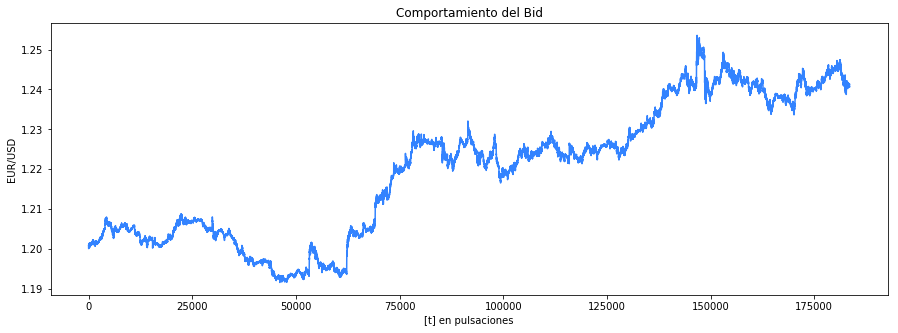

In [8]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del Bid')
plt.xlabel('[t] en pulsaciones')
plt.ylabel('EUR/USD')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,0], alpha=1, color='#3383FF');

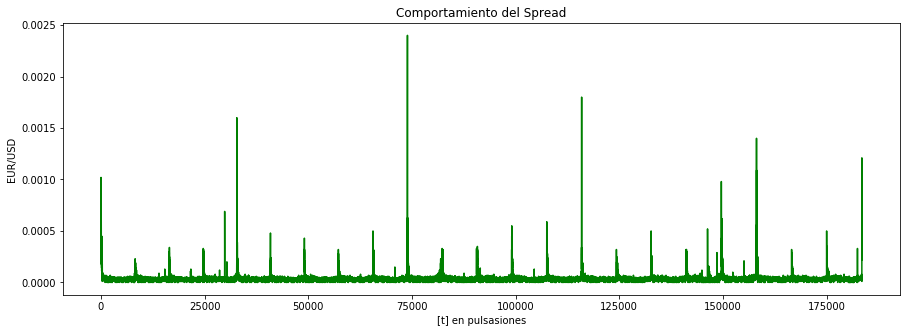

In [9]:
plt.figure(figsize=(15,5))
plt.title('Comportamiento del Spread')
plt.xlabel('[t] en pulsasiones')
plt.ylabel('EUR/USD')
plt.plot(np.arange(data_set.shape[0]), data_set.iloc[:,1] - data_set.iloc[:,0], alpha=1, color='green');

In [10]:
print('                   Bussines day - year, month, day')
print()
print(pd.unique(data_set.index.date))

                   Bussines day - year, month, day

[datetime.date(2018, 1, 1) datetime.date(2018, 1, 2)
 datetime.date(2018, 1, 3) datetime.date(2018, 1, 4)
 datetime.date(2018, 1, 5) datetime.date(2018, 1, 8)
 datetime.date(2018, 1, 9) datetime.date(2018, 1, 10)
 datetime.date(2018, 1, 11) datetime.date(2018, 1, 12)
 datetime.date(2018, 1, 15) datetime.date(2018, 1, 16)
 datetime.date(2018, 1, 17) datetime.date(2018, 1, 18)
 datetime.date(2018, 1, 19) datetime.date(2018, 1, 22)
 datetime.date(2018, 1, 23) datetime.date(2018, 1, 24)
 datetime.date(2018, 1, 25) datetime.date(2018, 1, 26)
 datetime.date(2018, 1, 29) datetime.date(2018, 1, 30)
 datetime.date(2018, 1, 31)]


#### Se crea un validation split
el "v_split" se crea para entrenar y validar el rendimiento del estimador, esa función retorna un generador con los indices de los dias que se tomarán para entrenar y los dias a validar. Los parametros que ella recibe son los siguientes:

   - X, que tiene que ser un dataframe indexado por fechas.
   - n_bdtrain, un entero el cual representa los días que se utilizarán para entrenar.
   - n_bdtest, un entero el cual representa los días que se utilizarán para validar.
   - mday, entero que representa los días que se va corriendo  el estimador para validar.

In [11]:
# Se crea un generador "v_split" para utilizar como método de validación cruzada
def v_split(X, n_bdtrain, n_bdtest, mday):

    """"
    Hace un particionado del dataset, para tomar n_bdtrain días para entrenar
    y n_bdtest para probar, además, mday representa el paso de día a correr.
    X, dataframe, se necesita el indice de este para separar por días.
    n_bdtrain, número de bussines day utilizados para train.
    n_bdtest, número de bussines day utilizados para test.
    mday, días a correr para cada validación.
    
    """
    from datetime import date
    start_day = 0
    
    #Divide el data set según días de train, test y cuanto se va moviendo
    bussines_day = []
    dates = pd.unique(X.index.date) #saco las fechas para luego tomar solo año-mes-día

    for i in dates: bussines_day.append(date.__format__(i,'%Y-%m-%d')) #lista de los bussines day
    
    intervals = []
    count = 0
    for i in bussines_day:
        f = len(X[i])-1 +count
        intervals.append([count,f])
        count = f+1
    
    for i in range(len(intervals)-n_bdtrain):
        yield(np.arange(intervals[start_day:start_day+n_bdtrain][0][0],
                        intervals[start_day:start_day+n_bdtrain][n_bdtrain-1][1]+1),
              np.arange(intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][0][0],
                        intervals[n_bdtrain+start_day:n_bdtrain+start_day+n_bdtest][n_bdtest-1][1]+1))
    
        start_day += mday
        if start_day+n_bdtest > len(intervals)-n_bdtrain:
            break

In [12]:
print("train data & test data")
print("----------------------")
for i in v_split(data_set,4,1,1):
    print (i)

train data & test data
----------------------
(array([    0,     1,     2, ..., 24640, 24641, 24642]), array([24643, 24644, 24645, ..., 32762, 32763, 32764]))
(array([    8,     9,    10, ..., 32762, 32763, 32764]), array([32765, 32766, 32767, ..., 40857, 40858, 40859]))
(array([ 8229,  8230,  8231, ..., 40857, 40858, 40859]), array([40860, 40861, 40862, ..., 48998, 48999, 49000]))
(array([16415, 16416, 16417, ..., 48998, 48999, 49000]), array([49001, 49002, 49003, ..., 57255, 57256, 57257]))
(array([24643, 24644, 24645, ..., 57255, 57256, 57257]), array([57258, 57259, 57260, ..., 65577, 65578, 65579]))
(array([32765, 32766, 32767, ..., 65577, 65578, 65579]), array([65580, 65581, 65582, ..., 73916, 73917, 73918]))
(array([40860, 40861, 40862, ..., 73916, 73917, 73918]), array([73919, 73920, 73921, ..., 82295, 82296, 82297]))
(array([49001, 49002, 49003, ..., 82295, 82296, 82297]), array([82298, 82299, 82300, ..., 90585, 90586, 90587]))
(array([57258, 57259, 57260, ..., 90585, 90586, 90

#### Se crea una función para construir el dataset ####
Con "build_dataset" lo que se quiere es que mediante la señal, un tamaño de ventana y otros parámetros que explicaré a continuación se genere el dataset como un dataframe indexado por sus fechas. Los parámetros de esta función son:

   - signal, señal a procesar, tiene que ser un dataframe indexado por las fechas.
   - window, tamaño de ventana a coger, este define las columnas del dataset.
   - binary_target, por defecto es False, determina si se quiere el target binario de los datos, esto me permite trabajar con clasificación.
   - delete_constant_values, por defecto es True, dado a que son datos que fluctuan poco, al momento de crear el dataset puede que para el target este se mantenga igual, que el precio no suba ni baje, por ende estos datos los elimino.
   - PNL, por defecto es False, este agrega una columna al dataframe, la cual consiste en anotar la ganancia o perdida según si sube o baja el precio del mercado.

In [13]:
# %load ../code/build_dataset.py
def build_dataset(df, window, binary_target=False, delete_constant_values=True, PNL=False):
    """
    función para construir un data set
    window: tamaño de la ventana a utilizar para construir el dataset
    df: dataframe, con columna bid y ask.
    binary_target: si desea clasificar, este arroja 2 si el valor se mantiene,
    1 si el valor sube y 0 si este baja.
    delete_constant_values: default: True, elimina los valores que se mantienen
    
    retorna:
    X: dataset, con columna de PNL si así se especifica(default: False)
    y: target
    bt: binary target, default: False
    """

    import pandas as pd
    import numpy as np
    result = []
    binary = [] #para la columna objetivo binaria
    pnl_buy = [] #almacenar el pnl en caso de compra
    pnl_sell = [] #almacenar el pnl en caso de venta
    signal = df.bid
    ask = df.ask
    indx = signal.index[window-1:-1] #se toman los indicen que quedarán al final
    for i in range(len(signal)-window):
        
        if delete_constant_values == True:
            if signal[i+window] != signal[i+window-1]:

                result.append(signal[i: i + window+1])
                if PNL == True: 
                    pnl_sell.append(signal[i+window-1] - ask[i+window]) #calcular pnl en caso de venta-compra
                    pnl_buy.append(signal[i+window] - ask[i+window-1]) #calcular pnl en caso de compra-venta
                
                if binary_target == True:
                    if signal[i+window] < signal[i+window-1]: binary.append(0) # 0 si baja
                    if signal[i+window] > signal[i+window-1]: binary.append(1) # 1 si sube
                        
            else: indx = indx.delete(len(result))
                
        else:

            result.append(signal[i: i + window+1])
            if PNL == True:
                pnl_sell.append(signal[i+window-1] - ask[i+window]) #calcular pnl en caso de venta-compra
                pnl_buy.append(signal[i+window] - ask[i+window-1]) #calcular pnl en caso de compra-venta
            
        if binary_target == True and delete_constant_values == False:
            if signal[i+window] == signal[i+window-1]: binary.append(2) # 2 si se mantiene
            if signal[i+window] < signal[i+window-1]: binary.append(0) # 1 si baja
            if signal[i+window] > signal[i+window-1]: binary.append(1) # 0 si sube
    
    data = pd.DataFrame(np.array(result), index=indx)
    y = np.array(data.iloc[:,window])
    data = data.drop(window,axis=1)
    if PNL == True:
        data['PNL_0'] = pnl_sell
        data['PNL_1'] = pnl_buy 
    if binary_target == True: return data, y, np.array(binary)
    else: return data, y

In [14]:
data_set.head()

,bid,ask
date,,
2018-01-01 23:58:00,1.20093,1.20115
2018-01-01 23:58:10,1.20093,1.20111
2018-01-01 23:58:20,1.20082,1.20111
2018-01-01 23:58:30,1.20043,1.20110
2018-01-01 23:58:50,1.20011,1.20113


#### Construyendo el dataset
se prueba construyendo el dataset con una ventana de tamaño 3 ya que con esta es que se obtuvo mejores resultados.

In [15]:
window = 3
X, y_reg, bt = build_dataset(data_set, window, binary_target=True, delete_constant_values=True, PNL=True)

In [16]:
X.shape, bt.shape, y_reg.shape

((156579, 5), (156579,), (156579,))

In [17]:
print(y_reg[:5])
print(bt[:5])

[ 1.20043  1.20011  1.20015  1.20028  1.20015]
[0 0 1 1 0]


Se utiliza cross_val_score pasandole el parámetro cv para la partición del dataset a la hora de entrenar y probrar, se utiliza la función score que este trae por defecto

In [17]:
from sklearn.model_selection import cross_val_score

y = bt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

n_bdtrain = 4 #número de dias con los que se entrena
n_bdtest = 1  #número de días con los que se hace el test
move_day = 1  #número de días que se van corriendo

vs = v_split(X,n_bdtrain,n_bdtest,move_day)
k = GaussianNB()

for train_index, test_index in vs:
    print ('train = ',train_index, 'test = ',test_index)
print()
result = cross_val_score(k, X, y, cv=v_split(X, n_bdtrain, n_bdtest, move_day))

print(result)
print()
print('score avg = ', np.mean(result))
print('score std = ', np.std(result))

train =  [    0     1     2 ..., 27017 27018 27019] test =  [27020 27021 27022 ..., 34030 34031 34032]
train =  [ 6739  6740  6741 ..., 34030 34031 34032] test =  [34033 34034 34035 ..., 40565 40566 40567]
train =  [13262 13263 13264 ..., 40565 40566 40567] test =  [40568 40569 40570 ..., 47252 47253 47254]
train =  [20136 20137 20138 ..., 47252 47253 47254] test =  [47255 47256 47257 ..., 54247 54248 54249]
train =  [27020 27021 27022 ..., 54247 54248 54249] test =  [54250 54251 54252 ..., 61143 61144 61145]
train =  [34033 34034 34035 ..., 61143 61144 61145] test =  [61146 61147 61148 ..., 67863 67864 67865]
train =  [40568 40569 40570 ..., 67863 67864 67865] test =  [67866 67867 67868 ..., 74494 74495 74496]
train =  [47255 47256 47257 ..., 74494 74495 74496] test =  [74497 74498 74499 ..., 81695 81696 81697]
train =  [54250 54251 54252 ..., 81695 81696 81697] test =  [81698 81699 81700 ..., 88440 88441 88442]
train =  [61146 61147 61148 ..., 88440 88441 88442] test =  [88443 88444 

train =  [345806 345807 345808 ..., 373876 373877 373878] test =  [373879 373880 373881 ..., 381291 381292 381293]
train =  [353013 353014 353015 ..., 381291 381292 381293] test =  [381294 381295 381296 ..., 388646 388647 388648]
train =  [359447 359448 359449 ..., 388646 388647 388648] test =  [388649 388650 388651 ..., 396060 396061 396062]
train =  [366604 366605 366606 ..., 396060 396061 396062] test =  [396063 396064 396065 ..., 403367 403368 403369]
train =  [373879 373880 373881 ..., 403367 403368 403369] test =  [403370 403371 403372 ..., 410814 410815 410816]
train =  [381294 381295 381296 ..., 410814 410815 410816] test =  [410817 410818 410819 ..., 418123 418124 418125]
train =  [388649 388650 388651 ..., 418123 418124 418125] test =  [418126 418127 418128 ..., 425324 425325 425326]
train =  [396063 396064 396065 ..., 425324 425325 425326] test =  [425327 425328 425329 ..., 432607 432608 432609]
train =  [403370 403371 403372 ..., 432607 432608 432609] test =  [432610 432611

se crea la clase PNLEstimatorWrapper para crear nuestra propia función score y así retornar nuestros diferentes tipos de score

In [18]:
# %load ../code/PNLEstimatorWrapper.py
import pandas as pd
import numpy as np
class PNLEstimatorWrapper:
    
    def __init__(self, estimator, PNL_column, exclude_PNL_column_from_training=True):
        self.estimator = estimator
        self.PNL_column = PNL_column
        self.exclude_PNL_column_from_training = exclude_PNL_column_from_training
        
    def fit(self, X, y):
        assert 'PNL_1' and 'PNL_0' in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column[0] and col!=self.PNL_column[1]]]
        self.estimator.fit(X,y)
        
    def predict(self, X):
        assert 'PNL_1' and 'PNL_0' in X.columns, "column "+self.PNL_column+" not in X dataframe"
        if self.exclude_PNL_column_from_training:
            X = X[[col for col in X.columns if col!=self.PNL_column[0] and col!=self.PNL_column[1]]]
        return self.estimator.predict(X)
    
    def score(self, X, y):
        pnl_1 = X[self.PNL_column[0]]
        pnl_0 = X[self.PNL_column[1]]
        pre = self.predict(X)
        r = sum((pre==1)*pnl_1 + (pre==0)*pnl_0)
        sell = sum((pre==0)*1)
        buy = sum((pre==1)*1)
        
        count_ones, count_zeros = 0,0
        l_one, l_zero = [],[]
        for i in pre:
            if i==1:
                l_zero.append(count_zeros)
                count_zeros = 0
                count_ones += 1
            else:
                l_one.append(count_ones)
                count_zeros += 1
                count_ones = 0
        l_zero.append(count_zeros)
        l_one.append(count_ones)
        
        #return np.array([r,buy,sell,max(l_one),max(l_zero)])
        return np.array([r,buy,sell,max(l_one),max(l_zero)]), pre
        
    def get_params(self, deep=False):
        return {"PNL_column": self.PNL_column,
                "exclude_PNL_column_from_training": self.exclude_PNL_column_from_training,
                "estimator": self.estimator}

#### creando la función step_validation
esta función me recibe el estimador en el cual va implicita la clase PNLEstimatorWrapper, lo que hace es coger el generador "v_split" para aplicarlo con el estimador y así validar los datos.


In [19]:
def step_validation(estimator, X, y, cv):
    '''
    Recibe el estimador,X,y, y un generador cv con el cual hace la validación
    dependiendo que la configuración que este tenga
    '''
    result = []
    for index in cv:
        estimator.fit(X.iloc[index[0]], y[index[0]])
        result.append(estimator.score(X.iloc[index[1]], y[index[1]]))
    return np.array(result)

Debido a que la función score arroja un vector que en cada posición tiene un vector con datos del PNL y otro con las predicciones, se hace necesario crear una función llamada "redim" para tratar esta salida y poder separar los datos del PNL y los del predict.

In [20]:
def redim(signal):
    '''
    recibe un array plano el cual convierte en dos salidas,
    en una de estas se encuentran los resultados pertinentes
    a medir con el PNL y en el otro las predicciones.
    '''
    result = signal[:,0][0]
    predict = np.array(signal[:,1][0],dtype=np.float16)
    for i in range(1,len(signal)):
        result = np.concatenate((result,signal[:,0][i]))
        predict = np.concatenate((predict,signal[:,1][i]))
    result = result.reshape((len(signal),signal[:,0][0].shape[0]))
    return result, predict

In [21]:
X.head()

,0,1,2,PNL_0,PNL_1
date,,,,,
2018-01-01 23:58:20,1.20093,1.20093,1.20082,-0.00028,-0.00068
2018-01-01 23:58:30,1.20093,1.20082,1.20043,-0.00070,-0.00099
2018-01-01 23:58:50,1.20082,1.20043,1.20011,-0.00099,-0.00098
2018-01-01 23:59:00,1.20043,1.20011,1.20015,-0.00095,-0.00082
2018-01-01 23:59:10,1.20011,1.20015,1.20028,-0.00082,-0.00095


In [22]:
y_reg[:5]

array([ 1.20043,  1.20011,  1.20015,  1.20028,  1.20015])

In [23]:
# se muestrea la señal a predecir por cada hora para colocar con los buy y sell por dia.
signal_sample = (X.resample('1h',loffset='h').last()).iloc[:,2][1:]

In [24]:
signal_sample.shape

(720,)

In [25]:
signal_sample.head()

date
2018-01-02 01:00:00    1.20057
2018-01-02 02:00:00    1.20092
2018-01-02 03:00:00    1.20170
2018-01-02 04:00:00    1.20161
2018-01-02 05:00:00    1.20097
Freq: H, Name: 2, dtype: float64

Se prueba con un GaussianNB para ver su rendimiento, esto teniendo cuenta que solo es con un mes de datos

In [30]:
from sklearn.naive_bayes import GaussianNB
    
est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column=['PNL_1','PNL_0'])
y = bt
n_bdtrain = 4
n_bdtest = 1
move_day = 1
#para indexar los resultados del dataframe
dates = pd.unique(X.index.date)[n_bdtrain:]
result_GNB = step_validation(est_GNB, X, y, v_split(X,n_bdtrain,n_bdtest,move_day))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('-------------------------------------')
df_GNB = pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells']), index=dates)
print(df_GNB)
df_GNB.to_csv('../resultados/TrueFX/EUR-USD/GaussianNB/pnl_GNB_wsize3_2018-01.csv')

--------- GaussianNB ----------------
average PNL :  -0.270086842105
average buy:  1753.05263158
average sell:  5455.52631579
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells
2018-01-05 -0.22388   125.0  6333.0          86.0         4331.0
2018-01-08 -0.23485  5370.0  1144.0        5088.0          939.0
2018-01-09 -0.21759  6655.0     0.0        6655.0            0.0
2018-01-10 -0.24520     0.0  7020.0           0.0         7020.0
2018-01-11 -0.25744     0.0  7112.0           0.0         7112.0
2018-01-12 -0.28993     0.0  7093.0           0.0         7093.0
2018-01-15 -0.28936  7099.0     0.0        7099.0            0.0
2018-01-16 -0.25366     0.0  7122.0           0.0         7122.0
2018-01-17 -0.28687     0.0  7539.0           0.0         7539.0
2018-01-18 -0.27218  3525.0  3833.0        2993.0         3694.0
2018-01-19 -0.27293   936.0  6375.0         322.0         5501.0
2018-01-22 -0.25306  1564.0  5587.0         752.0       

In [31]:
np.mean(result_GNB[:,0])

-0.27008684210526751

In [32]:
max(df_GNB.iloc[:,3]), max(df_GNB.iloc[:,4])

(7099.0, 7619.0)

### Se pintarán las ventas en color rojo y las compras en color verde!

para poder graficar la señal original con las predicciones, hay que tener en cuenta que los primeros 4 días que se eligieron anteriormente en la variable "n_bdtrain" se deben omitir.

In [33]:
firts_4bd = 19616 #primeros 4 días

el vector de predicción tiene el mismo tamaño que el vector de target, teniendo en cuenta que este empieza después de los 4 días que tenemos para entrenar desde un principio

In [34]:
len(predict_GNB),len(y)- firts_4bd

(136963, 136963)

In [35]:
y_reg[:5]

array([ 1.20043,  1.20011,  1.20015,  1.20028,  1.20015])

In [36]:
bt[:5], predict_GNB[:5]

(array([0, 0, 1, 1, 0]), array([ 0.,  0.,  0.,  0.,  0.]))

In [37]:
X.iloc[:6]

,0,1,2,PNL_0,PNL_1
date,,,,,
2018-01-01 23:58:20,1.20093,1.20093,1.20082,-0.00028,-0.00068
2018-01-01 23:58:30,1.20093,1.20082,1.20043,-0.00070,-0.00099
2018-01-01 23:58:50,1.20082,1.20043,1.20011,-0.00099,-0.00098
2018-01-01 23:59:00,1.20043,1.20011,1.20015,-0.00095,-0.00082
2018-01-01 23:59:10,1.20011,1.20015,1.20028,-0.00082,-0.00095
2018-01-02 00:00:40,1.20028,1.20015,1.20015,-0.00098,-0.00075


In [38]:
y_reg.shape, X.shape

((156579,), (156579, 5))

Como para el target se empieza del segundo valor de la fila X, es decir, el primer valor de la señal no tiene una predicción ya que no tiene un valor anterior para ser comparado, por esto se coge la señal "y_reg" y no se toma el último valor ya que este no tiene predicción

In [39]:
#para graficar las compras acertadas sobre la señal original
buy_GNB_ok = ((predict_GNB==bt[firts_4bd:])&(predict_GNB==1))*y_reg[firts_4bd-1:-1]
buy_GNB_ok[buy_GNB_ok==0] = np.nan 
print (buy_GNB_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_GNB_ok = ((predict_GNB==bt[firts_4bd:])&(predict_GNB==0))*y_reg[firts_4bd-1:-1]
sell_GNB_ok[sell_GNB_ok==0] = np.nan
print (sell_GNB_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_GNB_mal = ((predict_GNB!=bt[firts_4bd:])&(predict_GNB==1))*y_reg[firts_4bd-1:-1]
buy_GNB_mal[buy_GNB_mal==0] = np.nan 
print (buy_GNB_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_GNB_mal = ((predict_GNB!=bt[firts_4bd:])&(predict_GNB==0))*y_reg[firts_4bd-1:-1]
sell_GNB_mal[sell_GNB_mal==0] = np.nan
print (sell_GNB_mal.shape)

(136963,)
(136963,)
(136963,)
(136963,)


In [40]:
#dates = np.unique(X.index.date) #para graficar el numero de ventas y compras por dia
x_axis = X.index[firts_4bd:] #para graficar los resultados por datetime

In [41]:
x_axis.shape, sell_GNB_ok.shape

((136963,), (136963,))

In [44]:
x_axis

DatetimeIndex(['2018-01-05 00:00:00', '2018-01-05 00:00:10',
               '2018-01-05 00:00:20', '2018-01-05 00:00:30',
               '2018-01-05 00:01:00', '2018-01-05 00:01:20',
               '2018-01-05 00:01:50', '2018-01-05 00:02:00',
               '2018-01-05 00:02:20', '2018-01-05 00:02:40',
               ...
               '2018-01-31 23:57:30', '2018-01-31 23:57:40',
               '2018-01-31 23:57:50', '2018-01-31 23:58:00',
               '2018-01-31 23:58:10', '2018-01-31 23:58:30',
               '2018-01-31 23:58:50', '2018-01-31 23:59:00',
               '2018-01-31 23:59:10', '2018-01-31 23:59:20'],
              dtype='datetime64[ns]', name='date', length=136963, freq=None)

graficando con bokeh...

In [45]:
p1_GNB = bp.Figure(width=750, height=300,title='buys and sells with a GaussianNB',x_axis_type='datetime',
               title_location = 'above')
p1_GNB.triangle(x_axis, buy_GNB_ok, color='green', legend='predict buy ok')
p1_GNB.triangle(x_axis, sell_GNB_ok, color='green', legend='predict sells ok', angle=45)
p1_GNB.xaxis.axis_label = 'Datetime'
p1_GNB.yaxis.axis_label = 'EUR/USD'
p1_GNB.triangle(x_axis, buy_GNB_mal, color='red', legend='incorrect predict buy')
p1_GNB.triangle(x_axis, sell_GNB_mal, color='red', legend='incorrect predict sell', angle=45)
p1_GNB.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_GNB.legend.location = 'bottom_left'
p1_GNB.legend.orientation = 'horizontal'
p1_GNB.legend.background_fill_color = 'grey'
p1_GNB.legend.background_fill_alpha = 0.1
p1_GNB.legend.border_line_alpha = None

p2_GNB = bp.Figure(width=750, height=300,title='Profit and Loss with a GaussianNB',x_axis_type='datetime')
p2_GNB.line(dates, result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.circle(dates, result_GNB[:,0], color='blue', legend='PNL', alpha=0.5)
p2_GNB.line(dates, np.zeros(len(result_GNB)), color='red', legend='PNL = 0', line_dash='dotted')
p2_GNB.line(dates,np.ones(len(result_GNB[:,0]))*np.mean(result_GNB[:,0]),color='green',legend='avg PNL')
p2_GNB.xaxis.axis_label = 'datetime'
p2_GNB.yaxis.axis_label = 'PNL'
p2_GNB.legend.location ='bottom_center'
p2_GNB.legend.orientation = 'horizontal'

p3_GNB = bp.Figure(width=450, height=250, title='buys and sells per day', x_axis_type='datetime')
p3_GNB.line(dates, result_GNB[:,1], color='green', legend='buys')
p3_GNB.circle(dates, result_GNB[:,1], color='green', legend='buys')
p3_GNB.line(dates, result_GNB[:,2], color='red', legend='sells')
p3_GNB.circle(dates, result_GNB[:,2], color='red', legend='sells')
p3_GNB.xaxis.axis_label = 'datetime'
p3_GNB.yaxis.axis_label = 'quantity'
p3_GNB.legend.location = 'top_left'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x

#para pintar el PNL que se va acumulando
PNL_accu_GNB = []
count_GNB = 0
for i in result_GNB[:,0]:
    count_GNB += i
    PNL_accu_GNB.append(count_GNB)
#se pinta el PNL acumulado
p5_GNB = bp.Figure(width=750, height=300,title='PNL accumulated with a GaussianNB',x_axis_type='datetime',
                   x_range=p2_GNB.x_range)
p5_GNB.line(dates,PNL_accu_GNB,color='blue',legend='PNL accumulated',alpha=0.5)
p5_GNB.circle(dates, PNL_accu_GNB, color='blue',legend='PNL accumulated', alpha=0.5)
p5_GNB.line(dates, np.zeros(len(result_GNB)), color='red', legend='PNL = 0', line_dash='dotted')
p5_GNB.xaxis.axis_label = 'datetime'
p5_GNB.yaxis.axis_label = 'PNL accumulated'
p5_GNB.legend.location ='bottom_center'
p5_GNB.legend.orientation = 'horizontal'

#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_GNB = bp.Figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_GNB.x_range)
p6_GNB.line(signal_sample.index, signal_sample, color='blue')
p6_GNB.xaxis.axis_label = 'datetime'
p6_GNB.yaxis.axis_label = 'bid EUR/USD'

bp.show(gridplot([[p1_GNB,p3_GNB],[p2_GNB,p6_GNB],[p5_GNB]], toolbar_location="right"))
bp.output_file(filename='../resultados/TrueFX/EUR-USD/GaussianNB/grafico GaussianNB.html', title='GaussianNB')

se gráfica el PNL y su media para poder ver graficamente las veces que se gana o se pierde y si en general se termina ganando o perdiendo dinero

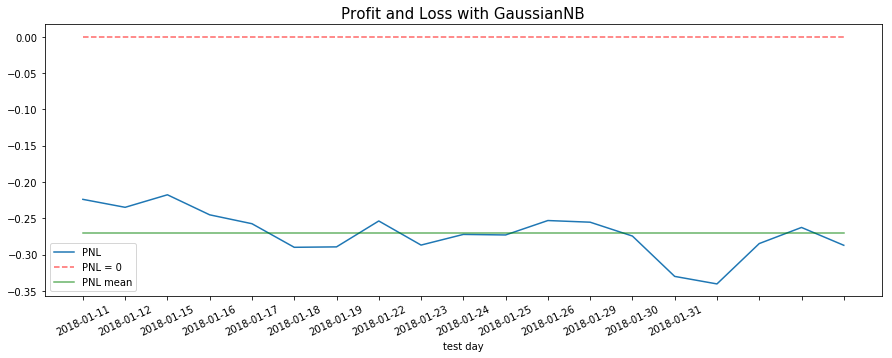

In [48]:
plt.figure(figsize=(15,5))
    
plt.title('Profit and Loss with GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,0])), result_GNB[:,0], label='PNL')
plt.plot(range(len(result_GNB[:,0])), np.zeros(len(result_GNB[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_GNB[:,0])), np.ones(len(result_GNB[:,0]))*np.mean(result_GNB[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

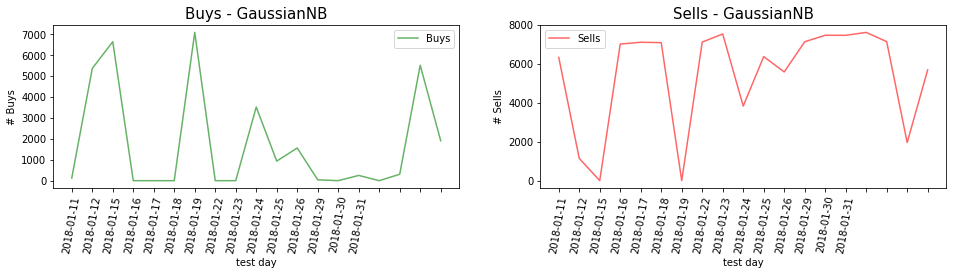

In [49]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buys - GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,1])), result_GNB[:,1],color='green', alpha=0.6, label='Buys')
plt.xlabel('test day')
plt.ylabel('# Buys')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();
    
plt.subplot(1,2,2)
plt.title('Sells - GaussianNB', size=15)
plt.plot(range(len(result_GNB[:,2])), result_GNB[:,2],color='red', alpha=0.6, label='Sells')
plt.xlabel('test day')
plt.ylabel('# Sells')
plt.xticks(range(len(result_GNB)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

Se prueba con un KNeighborsClassifier

In [50]:
dates.shape

(19,)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column=['PNL_1','PNL_0'])
result_KNC = step_validation(est_KNC, X, y, v_split(X,4,1,1))
result_KNC, predict_KNC = redim(result_KNC)
print('-------- KNeighborsClassifier -------')
print('average PNL: ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('-------------------------------------')
df_KNC = pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells']), index=dates)
print(df_KNC)
df_KNC.to_csv('../resultados/TrueFX/EUR-USD/KNeighborsClassfier/pnl_KNC_wsize3_2018-01.csv')

-------- KNeighborsClassifier -------
average PNL:  -0.272484736842
average buy:  3167.84210526
average sell:  4040.73684211
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells
2018-01-05 -0.23473  3039.0  3419.0          18.0           17.0
2018-01-08 -0.23443  5217.0  1297.0        3067.0           11.0
2018-01-09 -0.21357  5474.0  1181.0        4206.0           26.0
2018-01-10 -0.25319  3111.0  3909.0          22.0          101.0
2018-01-11 -0.25477  3276.0  3836.0          11.0           17.0
2018-01-12 -0.28979   835.0  6258.0          18.0         4418.0
2018-01-15 -0.29855  1075.0  6024.0          59.0         4150.0
2018-01-16 -0.25825  3432.0  3690.0          43.0           49.0
2018-01-17 -0.28553  3595.0  3944.0          16.0          177.0
2018-01-18 -0.27951  3981.0  3377.0          39.0           11.0
2018-01-19 -0.28711  3518.0  3793.0          13.0           13.0
2018-01-22 -0.25264  3410.0  3741.0          14.0        

#### Pintando con bokeh, se guarda la imagen debido a que consume una cantidad de memoria RAM considerable

In [53]:
#para graficar las compras acertadas sobre la señal original
buy_KNC_ok = ((predict_KNC==bt[firts_4bd:])&(predict_KNC==1))*y_reg[firts_4bd-1:-1]
buy_KNC_ok[buy_KNC_ok==0] = np.nan 
print (buy_KNC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_KNC_ok = ((predict_KNC==bt[firts_4bd:])&(predict_KNC==0))*y_reg[firts_4bd-1:-1]
sell_KNC_ok[sell_KNC_ok==0] = np.nan
print (sell_KNC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_KNC_mal = ((predict_KNC!=bt[firts_4bd:])&(predict_KNC==1))*y_reg[firts_4bd-1:-1]
buy_KNC_mal[buy_KNC_mal==0] = np.nan 
print (buy_KNC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_KNC_mal = ((predict_KNC!=bt[firts_4bd:])&(predict_KNC==0))*y_reg[firts_4bd-1:-1]
sell_KNC_mal[sell_KNC_mal==0] = np.nan
print (sell_KNC_mal.shape)

(136963,)
(136963,)
(136963,)
(136963,)


al parecer si uso bp.reset_output y luego ejecuto dos veces la celda de graficar, esto no me genera conflicto

In [54]:
bp.reset_output()

In [55]:
p1_KNC = bp.Figure(width=750, height=300,title='buys and sells with a KNeighborsClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_KNC.triangle(x_axis, buy_KNC_ok, color='green', legend='predict buys ok')
p1_KNC.triangle(x_axis, sell_KNC_ok, color='green', legend='predict sells ok', angle=45)
p1_KNC.xaxis.axis_label = 'Datetime'
p1_KNC.yaxis.axis_label = 'EUR/USD'
p1_KNC.triangle(x_axis, buy_KNC_mal, color='red', legend='incorrect predict buys')
p1_KNC.triangle(x_axis, sell_KNC_mal, color='red', legend='incorrect predict sells', angle=45)
p1_KNC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_KNC.legend.location = 'bottom_left'
p1_KNC.legend.orientation = 'horizontal'
p1_KNC.legend.background_fill_color = 'grey'
p1_KNC.legend.background_fill_alpha = 0.1
p1_KNC.legend.border_line_alpha = None

p2_KNC = bp.Figure(width=750, height=300,title='Profit and Loss with a KNeighborsClassifier',x_axis_type='datetime')
p2_KNC.line(dates, result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.circle(dates, result_KNC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_KNC.line(dates, np.zeros(len(result_KNC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_KNC.line(dates,np.ones(len(result_KNC[:,0]))*np.mean(result_KNC[:,0]),color='green',legend='avg PNL')
p2_KNC.xaxis.axis_label = 'datetime'
p2_KNC.yaxis.axis_label = 'PNL'
p2_KNC.legend.location ='bottom_center'
p2_KNC.legend.orientation = 'horizontal'

p3_KNC = bp.Figure(width=400, height=250, title='buys and sells per day', x_axis_type='datetime')
p3_KNC.line(dates, result_KNC[:,1], color='green', legend='buys')
p3_KNC.circle(dates, result_KNC[:,1], color='green', legend='buys')
p3_KNC.line(dates, result_KNC[:,2], color='red',legend='sells')
p3_KNC.circle(dates, result_KNC[:,2], color='red', legend='sells')
p3_KNC.xaxis.axis_label = 'datetime'
p3_KNC.yaxis.axis_label = 'quantity'
p3_KNC.legend.location = 'top_left'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x
#para pintar el PNL que se va acumulando
PNL_accu_KNC = []
count_KNC = 0
for i in result_KNC[:,0]:
    count_KNC += i
    PNL_accu_KNC.append(count_KNC)
    
p5_KNC = bp.Figure(width=750, height=300,title='PNL accumulated with a KNeighborsClassifier',x_axis_type='datetime',
                   x_range=p2_KNC.x_range)
p5_KNC.line(dates,PNL_accu_KNC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_KNC.circle(dates, PNL_accu_KNC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_KNC.line(dates, np.zeros(len(result_KNC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_KNC.xaxis.axis_label = 'datetime'
p5_KNC.yaxis.axis_label = 'PNL accumulated'
p5_KNC.legend.location ='bottom_center'
p5_KNC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_KNC = bp.Figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_KNC.x_range)
p6_KNC.line(signal_sample.index, signal_sample, color='blue')
p6_KNC.xaxis.axis_label = 'datetime'
p6_KNC.yaxis.axis_label = 'bid EUR/USD'

bp.show(gridplot([[p1_KNC,p3_KNC],[p2_KNC,p6_KNC],[p5_KNC]], toolbar_location="right"))
bp.output_file(filename='../resultados/TrueFX/EUR-USD/KNeighborsClassfier/grafico KNeihgborsClassifier.html', title='KNeihgborsClassifier')

se gráfica el PNL y su media para poder ver graficamente las veces que se gana o se pierde y si en general se termina ganando o perdiendo dinero

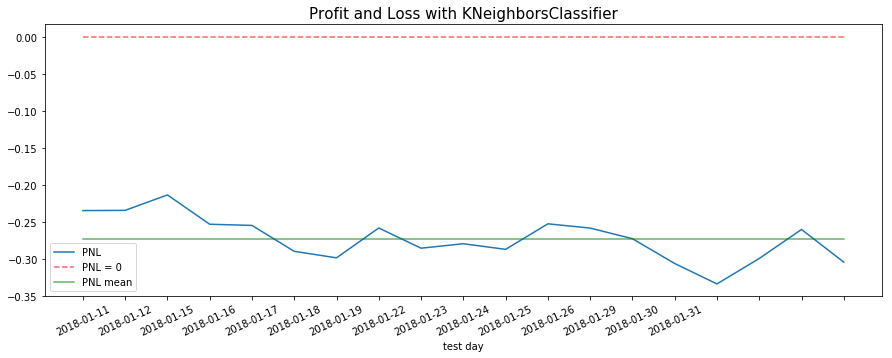

In [57]:
plt.figure(figsize=(15,5))
    
plt.title('Profit and Loss with KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,0])), result_KNC[:,0], label='PNL')
plt.plot(range(len(result_KNC[:,0])), np.zeros(len(result_KNC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_KNC[:,0])), np.ones(len(result_KNC[:,0]))*np.mean(result_KNC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

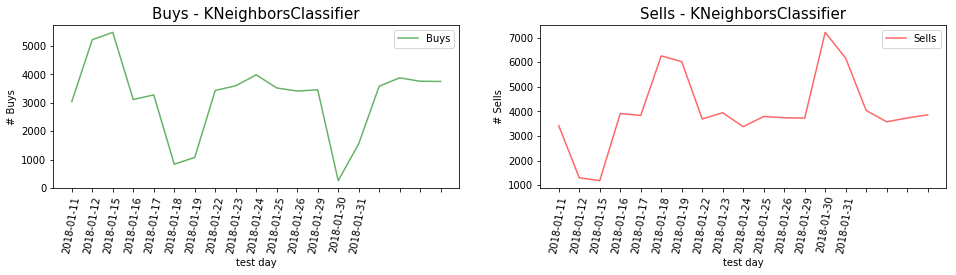

In [58]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buys - KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,1])), result_KNC[:,1],color='green', alpha=0.6, label='Buys')
plt.xlabel('test day')
plt.ylabel('# Buys')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sells - KNeighborsClassifier', size=15)
plt.plot(range(len(result_KNC[:,2])), result_KNC[:,2],color='red', alpha=0.6, label='Sells')
plt.xlabel('test day')
plt.ylabel('# Sells')
plt.xticks(range(len(result_KNC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

se prueba con un DecisionTreeClassifier

In [44]:
from sklearn.tree import DecisionTreeClassifier

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column=['PNL_0','PNL_1'])
result_DTC = step_validation(est_DTC, X, y, v_split(X,4,1,1))
result_DTC, predict_DTC = redim(result_DTC)
print('------ DecisionTreeClassifier -------')
print('average PNL: ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('-------------------------------------')
df_DTC = pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells']), index=dates)
print(df_DTC)
df_DTC.to_csv('../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/pnl_DTC_wsize3_2018-01.csv')

------ DecisionTreeClassifier -------
average PNL:  -0.272001052632
average buy:  3777.84210526
average sell:  3430.73684211
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells
2018-01-05 -0.22943  3128.0  3330.0          15.0           16.0
2018-01-08 -0.22972  5169.0  1345.0        3067.0           11.0
2018-01-09 -0.20940  5344.0  1311.0        4206.0           17.0
2018-01-10 -0.25153  3317.0  3703.0          14.0           60.0
2018-01-11 -0.24687  3386.0  3726.0          14.0           15.0
2018-01-12 -0.28193  5757.0  1336.0        4368.0           19.0
2018-01-15 -0.29357  1109.0  5990.0          24.0         4161.0
2018-01-16 -0.25543  3440.0  3682.0          27.0           16.0
2018-01-17 -0.30550  3489.0  4050.0          12.0          149.0
2018-01-18 -0.26795  3602.0  3756.0          18.0           13.0
2018-01-19 -0.28314  3521.0  3790.0          13.0           19.0
2018-01-22 -0.26261  3506.0  3645.0          13.0        

In [60]:
#para graficar las compras acertadas sobre la señal original
buy_DTC_ok = ((predict_DTC==bt[firts_4bd:])&(predict_DTC==1))*y_reg[firts_4bd-1:-1]
buy_DTC_ok[buy_DTC_ok==0] = np.nan 
print (buy_DTC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_DTC_ok = ((predict_DTC==bt[firts_4bd:])&(predict_DTC==0))*y_reg[firts_4bd-1:-1]
sell_DTC_ok[sell_DTC_ok==0] = np.nan
print (sell_DTC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_DTC_mal = ((predict_DTC!=bt[firts_4bd:])&(predict_DTC==1))*y_reg[firts_4bd-1:-1]
buy_DTC_mal[buy_DTC_mal==0] = np.nan 
print (buy_DTC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_DTC_mal = ((predict_DTC!=bt[firts_4bd:])&(predict_DTC==0))*y_reg[firts_4bd-1:-1]
sell_DTC_mal[sell_DTC_mal==0] = np.nan
print (sell_DTC_mal.shape)

(136963,)
(136963,)
(136963,)
(136963,)


se guarda el gráfico de bokeh debido que si se pinta en el jupyter se va consumiendo mucha memoria ram

In [61]:
bp.reset_output()

In [62]:
p1_DTC = bp.figure(width=750, height=300,title='buys and sells with a DecisionTreeClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_DTC.triangle(x_axis, buy_DTC_ok, color='green', legend='predict buys ok')
p1_DTC.triangle(x_axis, sell_DTC_ok, color='green', legend='predict sells ok', angle=45)
p1_DTC.xaxis.axis_label = 'Datetime'
p1_DTC.yaxis.axis_label = 'EUR/USD'
p1_DTC.triangle(x_axis, buy_DTC_mal, color='red', legend='incorrect predict buy')
p1_DTC.triangle(x_axis, sell_DTC_mal, color='red', legend='incorrect predict sell', angle=45)
p1_DTC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_DTC.legend.location = 'bottom_left'
p1_DTC.legend.orientation = 'horizontal'
p1_DTC.legend.background_fill_color = 'grey'
p1_DTC.legend.background_fill_alpha = 0.1
p1_DTC.legend.border_line_alpha = None

p2_DTC = bp.figure(width=750, height=300,title='Profit and Loss with a DecisionTreeClassifier'
                   ,x_axis_type='datetime')
p2_DTC.line(dates, result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.circle(dates, result_DTC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_DTC.line(dates, np.zeros(len(result_DTC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_DTC.line(dates,np.ones(len(result_DTC[:,0]))*np.mean(result_DTC[:,0]),color='green',legend='avg PNL')
p2_DTC.xaxis.axis_label = 'datetime'
p2_DTC.yaxis.axis_label = 'PNL'
p2_DTC.legend.location ='bottom_center'
p2_DTC.legend.orientation = 'horizontal'

p3_DTC = bp.figure(width=400, height=250, title='buys and sells per day', x_axis_type='datetime')
p3_DTC.line(dates, result_DTC[:,1], color='green', legend='buys')
p3_DTC.circle(dates, result_DTC[:,1], color='green', legend='buys')
p3_DTC.line(dates, result_DTC[:,2], color='red', legend='sells')
p3_DTC.circle(dates, result_DTC[:,2], color='red', legend='sells')
p3_DTC.xaxis.axis_label = 'datetime'
p3_DTC.yaxis.axis_label = 'quantity'
p3_DTC.legend.location = 'top_left'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x

#para pintar el PNL que se va acumulando
PNL_accu_DTC = []
count_DTC = 0
for i in result_DTC[:,0]:
    count_DTC += i
    PNL_accu_DTC.append(count_DTC)
    
p5_DTC = bp.figure(width=750, height=300,title='PNL accumulated with a DecisionTreeClassifier',
                   x_axis_type='datetime',x_range=p2_DTC.x_range)
p5_DTC.line(dates,PNL_accu_DTC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_DTC.circle(dates, PNL_accu_DTC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_DTC.line(dates, np.zeros(len(result_DTC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_DTC.xaxis.axis_label = 'datetime'
p5_DTC.yaxis.axis_label = 'PNL accumulated'
p5_DTC.legend.location ='bottom_center'
p5_DTC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_DTC = bp.figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_DTC.x_range)
p6_DTC.line(signal_sample.index, signal_sample, color='blue')
p6_DTC.xaxis.axis_label = 'datetime'
p6_DTC.yaxis.axis_label = 'bid EUR/USD'

bp.show(gridplot([[p1_DTC,p3_DTC],[p2_DTC,p6_DTC],[p5_DTC]], toolbar_location="right"))
bp.output_file(filename='../resultados/TrueFX/EUR-USD/DecisionTreeClassifier/grafico DecisionTreeClassifier.html', title='DecisionTreeClassifier')

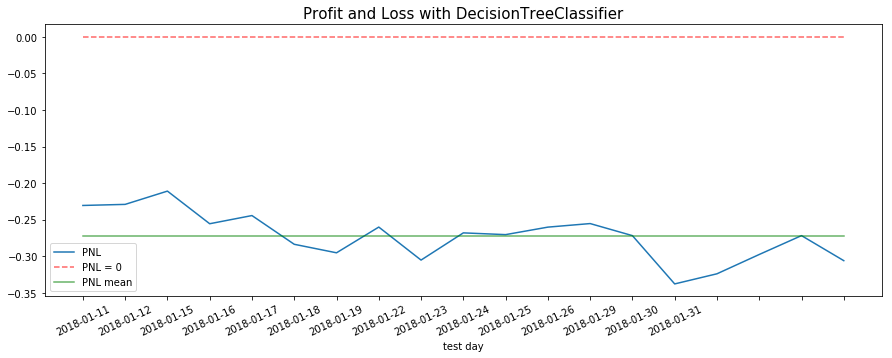

In [65]:
plt.figure(figsize=(15,5))

plt.title('Profit and Loss with DecisionTreeClassifier', size=15)
plt.plot(range(len(result_DTC[:,0])), result_DTC[:,0], label='PNL')
plt.plot(range(len(result_DTC[:,0])), np.zeros(len(result_DTC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_DTC[:,0])), np.ones(len(result_DTC[:,0]))*np.mean(result_DTC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

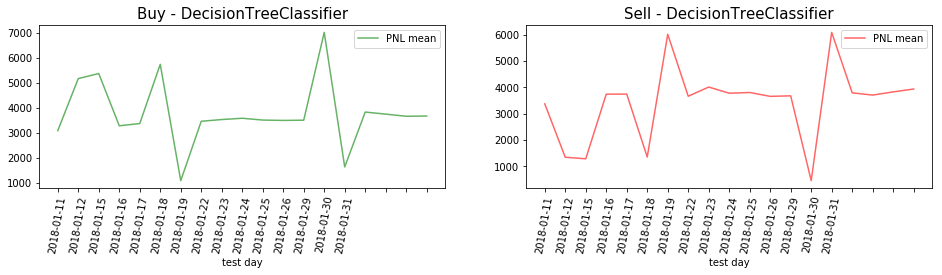

In [66]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buy - DecisionTreeClassifier', size=15),
plt.plot(range(len(result_DTC[:,1])), result_DTC[:,1],color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sell - DecisionTreeClassifier', size=15)
plt.plot(range(len(result_DTC[:,2])), result_DTC[:,2],color='red', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_DTC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

probando con un RandomForestClassifier, con ciertos parametros establecidos los cuales me han arrojado mejores resultados

In [45]:
from sklearn.ensemble import RandomForestClassifier

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column=['PNL_0','PNL_1'])
result_RFC = step_validation(est_RFC, X, y, v_split(X,4,1,1))
result_RFC, predict_RFC = redim(result_RFC)
print('RandomForestClassifier')
print('PNL promedio: ', np.mean(result_RFC[:,0]))
print('buy promedio: ', np.mean(result_RFC[:,1]))
print('sell promedio: ', np.mean(result_RFC[:,2]))
print('-------------------------------------')
df_RFC = pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells']), index=dates)
print(df_RFC)
df_RFC.to_csv('../resultados/TrueFX/EUR-USD/RandomForestClassifier/pnl_RFC_wsize3_2018-01.csv')

RandomForestClassifier
PNL promedio:  -0.272394736842
buy promedio:  3428.0
sell promedio:  3780.57894737
-------------------------------------
                PNL    buys   sells  longest_buys  longest_sells
2018-01-05 -0.22584  3071.0  3387.0          17.0           15.0
2018-01-08 -0.22996  5233.0  1281.0        3067.0           11.0
2018-01-09 -0.21196  5450.0  1205.0        4207.0           13.0
2018-01-10 -0.25039  3189.0  3831.0          15.0           52.0
2018-01-11 -0.25002  3312.0  3800.0          12.0           18.0
2018-01-12 -0.28432  5731.0  1362.0        4368.0           23.0
2018-01-15 -0.29065  1032.0  6067.0          29.0         3966.0
2018-01-16 -0.23881  3329.0  3793.0          27.0           22.0
2018-01-17 -0.30347  3576.0  3963.0          13.0          141.0
2018-01-18 -0.27852  3763.0  3595.0          21.0           12.0
2018-01-19 -0.28238  3499.0  3812.0          12.0           17.0
2018-01-22 -0.26635  3538.0  3613.0          14.0           13.0
2018-01-23 

In [68]:
#para graficar las compras acertadas sobre la señal original
buy_RFC_ok = ((predict_RFC==bt[firts_4bd:])&(predict_RFC==1))*y_reg[firts_4bd-1:-1]
buy_RFC_ok[buy_RFC_ok==0] = np.nan 
print (buy_RFC_ok.shape)
#para graficar las ventas acertadas sobre la señal original
sell_RFC_ok = ((predict_RFC==bt[firts_4bd:])&(predict_RFC==0))*y_reg[firts_4bd-1:-1]
sell_RFC_ok[sell_RFC_ok==0] = np.nan
print (sell_RFC_ok.shape)

#para graficar las compras fallidas sobre la señal original
buy_RFC_mal = ((predict_RFC!=bt[firts_4bd:])&(predict_RFC==1))*y_reg[firts_4bd-1:-1]
buy_RFC_mal[buy_RFC_mal==0] = np.nan 
print (buy_RFC_mal.shape)
#para graficar las ventas fallidas sobre la señal original
sell_RFC_mal = ((predict_RFC!=bt[firts_4bd:])&(predict_RFC==0))*y_reg[firts_4bd-1:-1]
sell_RFC_mal[sell_RFC_mal==0] = np.nan
print (sell_RFC_mal.shape)

(136963,)
(136963,)
(136963,)
(136963,)


In [69]:
bp.reset_output()

In [70]:
p1_RFC = bp.figure(width=750, height=300,title='buys and sells with a RandomForestClassifier',x_axis_type='datetime',
               title_location = 'above')
p1_RFC.triangle(x_axis, buy_RFC_ok, color='green', legend='predict buys ok')
p1_RFC.triangle(x_axis, sell_RFC_ok, color='green', legend='predict sells ok', angle=45)
p1_RFC.xaxis.axis_label = 'Datetime'
p1_RFC.yaxis.axis_label = 'EUR/USD'
p1_RFC.triangle(x_axis, buy_RFC_mal, color='red', legend='incorrect predict buy')
p1_RFC.triangle(x_axis, sell_RFC_mal, color='red', legend='incorrect predict bad', angle=45)
p1_RFC.line(x_axis, y_reg[firts_4bd-1:-1], color='blue', alpha=0.2, legend='bid')
p1_RFC.legend.location = 'bottom_left'
p1_RFC.legend.orientation = 'horizontal'
p1_RFC.legend.background_fill_color = 'grey'
p1_RFC.legend.background_fill_alpha = 0.1
p1_RFC.legend.border_line_alpha = None

p2_RFC = bp.figure(width=750, height=300,title='Profit and Loss with a RandomForestClassifier'
                   ,x_axis_type='datetime')
p2_RFC.line(dates, result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.circle(dates, result_RFC[:,0], color='blue', legend='PNL', alpha=0.5)
p2_RFC.line(dates, np.zeros(len(result_RFC)), color='red', legend='PNL = 0', line_dash='dotted')
p2_RFC.line(dates,np.ones(len(result_RFC[:,0]))*np.mean(result_RFC[:,0]),color='green',legend='avg PNL')
p2_RFC.xaxis.axis_label = 'datetime'
p2_RFC.yaxis.axis_label = 'PNL'
p2_RFC.legend.location ='bottom_center'
p2_RFC.legend.orientation = 'horizontal'

p3_RFC = bp.figure(width=400, height=250, title='buys and sells per day', x_axis_type='datetime')
p3_RFC.line(dates, result_RFC[:,1], color='green', legend='buys')
p3_RFC.circle(dates, result_RFC[:,1], color='green', legend='buys')
p3_RFC.line(dates, result_RFC[:,2], color='red', legend='sells')
p3_RFC.circle(dates, result_RFC[:,2], color='red', legend='sells')
p3_RFC.xaxis.axis_label = 'datetime'
p3_RFC.yaxis.axis_label = 'quantity'
p3_RFC.legend.location = 'top_left'
#se utiliza el x_range para correlacionar las dos gráficas por el eje x

#para pintar el PNL que se va acumulando
PNL_accu_RFC = []
count_RFC = 0
for i in result_RFC[:,0]:
    count_RFC += i
    PNL_accu_RFC.append(count_RFC)
    
p5_RFC = bp.figure(width=750, height=300,title='PNL accumulated with a RandomForestClassifier',
                   x_axis_type='datetime',x_range=p2_RFC.x_range)
p5_RFC.line(dates,PNL_accu_RFC,color='blue',legend='PNL accumulated',alpha=0.5)
p5_RFC.circle(dates, PNL_accu_RFC, color='blue',legend='PNL accumulated', alpha=0.5)
p5_RFC.line(dates, np.zeros(len(result_RFC)), color='red', legend='PNL = 0', line_dash='dotted')
p5_RFC.xaxis.axis_label = 'datetime'
p5_RFC.yaxis.axis_label = 'PNL accumulated'
p5_RFC.legend.location ='bottom_center'
p5_RFC.legend.orientation = 'horizontal'
#se pinta la señal submuestreada para verlas con en volumen de compras y ventas por día
p6_RFC = bp.figure(width=400, height=250, title='signal per hours', x_axis_type='datetime',x_range=p3_RFC.x_range)
p6_RFC.line(signal_sample.index, signal_sample, color='blue')
p6_RFC.xaxis.axis_label = 'datetime'
p6_RFC.yaxis.axis_label = 'bid EUR/USD'

bp.show(gridplot([[p1_RFC,p3_RFC],[p2_RFC,p6_RFC],[p5_RFC]], toolbar_location="right"))
bp.output_file(filename='../resultados/TrueFX/EUR-USD/RandomForestClassifier/egrafico RandomForestClassifier.html', title='RandomForestClassifier')

In [71]:
PNL_accu_RFC[-1]

-5.1782500000000518

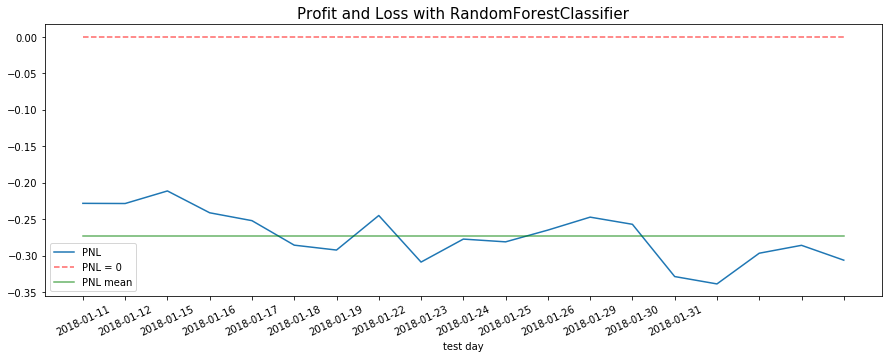

In [72]:
plt.figure(figsize=(15,5))

plt.title('Profit and Loss with RandomForestClassifier', size=15)
plt.plot(range(len(result_RFC[:,0])), result_RFC[:,0], label='PNL')
plt.plot(range(len(result_RFC[:,0])), np.zeros(len(result_RFC[:,0])),color='red', alpha=0.6, label='PNL = 0', linestyle='--')
plt.plot(range(len(result_RFC[:,0])), np.ones(len(result_RFC[:,0]))*np.mean(result_RFC[:,0]),
         color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=25)
plt.legend();

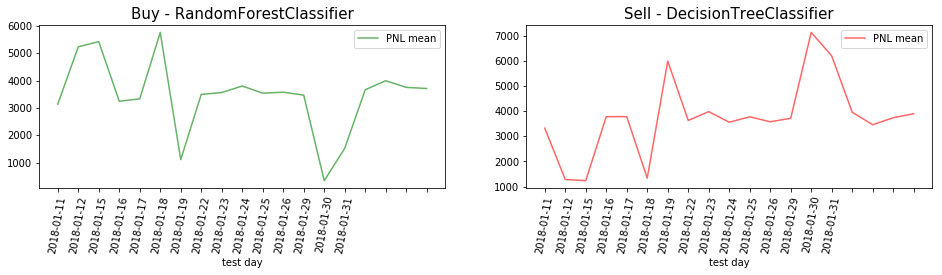

In [73]:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
plt.title('Buy - RandomForestClassifier', size=15)
plt.plot(range(len(result_RFC[:,1])), result_RFC[:,1],color='green', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

plt.subplot(1,2,2)
plt.title('Sell - DecisionTreeClassifier', size=15)
plt.plot(range(len(result_RFC[:,2])), result_RFC[:,2],color='red', alpha=0.6, label='PNL mean')
plt.xlabel('test day')
plt.xticks(range(len(result_RFC)),dates[n_bdtrain:], size=10, rotation=80)
plt.legend();

#### Se probará con multiples señales de entrada para experimentar como se comportan estos modelos..

In [137]:
#Se lee la señal correspondiente a GBP vs USD para el mes de enero de 2018
data_GBPvsUSD = pd.read_csv("../data/TrueFX/GBP-USD/GBPUSD-preprocesado-2018-01.csv", index_col=0
                            ,infer_datetime_format=True, parse_dates=True )

#Se lee la señal correspondiente a EUR vs USD para el mes de enero de 2018
data_EURvsUSD = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_EURUSD-2018-01.csv", index_col=0
                            ,infer_datetime_format=True, parse_dates=True )

In [138]:
data_EURvsUSD.head()

,bid,ask
date,,
2018-01-01 23:58:00,1.20093,1.20115
2018-01-01 23:58:10,1.20093,1.20111
2018-01-01 23:58:20,1.20082,1.20111
2018-01-01 23:58:30,1.20043,1.20110
2018-01-01 23:58:50,1.20011,1.20113


In [139]:
data_GBPvsUSD.head()

,bid,ask
date,,
2018-01-02 00:00:40,1.34979,1.35176
2018-01-02 00:01:00,1.34918,1.35208
2018-01-02 00:01:10,1.34915,1.35354
2018-01-02 00:01:20,1.34915,1.35386
2018-01-02 00:01:30,1.34938,1.35440


In [140]:
data_EURvsUSD.shape, data_GBPvsUSD.shape

((183535, 2), (185443, 2))

In [141]:
#saco los valores que si están en el mismo instante de tiempo
values = data_GBPvsUSD.filter(items=data_EURvsUSD.index, axis=0)

In [142]:
#inserto una columa llena de ceros para posteriormente colocar ahi los valores a utilizar
data_EURvsUSD.insert(loc=2, column='bidGBP/USD', value=np.zeros((data_EURvsUSD.shape[0],1)))

In [143]:
data_EURvsUSD.head()

,bid,ask,bidGBP/USD
date,,,
2018-01-01 23:58:00,1.20093,1.20115,0.0
2018-01-01 23:58:10,1.20093,1.20111,0.0
2018-01-01 23:58:20,1.20082,1.20111,0.0
2018-01-01 23:58:30,1.20043,1.20110,0.0
2018-01-01 23:58:50,1.20011,1.20113,0.0


procedemos al llenado de los datos con los que contamos, van a quedar algunos en cero debido a que en ciertos instantes de tiempo no se cuenta con esos datos..

In [144]:
data_EURvsUSD.loc[values.index,'bidGBP/USD'] = values.loc[values.index,'bid']

In [145]:
data_EURvsUSD[:10]

,bid,ask,bidGBP/USD
date,,,
2018-01-01 23:58:00,1.20093,1.20115,0.00000
2018-01-01 23:58:10,1.20093,1.20111,0.00000
2018-01-01 23:58:20,1.20082,1.20111,0.00000
2018-01-01 23:58:30,1.20043,1.20110,0.00000
2018-01-01 23:58:50,1.20011,1.20113,0.00000
2018-01-01 23:59:00,1.20015,1.20110,0.00000
2018-01-01 23:59:10,1.20028,1.20110,0.00000
2018-01-01 23:59:50,1.20015,1.20110,0.00000
2018-01-02 00:00:40,1.20015,1.20105,1.34979


ahora lo que haremos es llenar estos ceros con el mismo dato del bid del par EUR/USD

In [146]:
data_EURvsUSD.loc[data_EURvsUSD.loc[data_EURvsUSD.index,'bidGBP/USD']==0, 'bidGBP/USD'] = data_EURvsUSD.loc[data_EURvsUSD.loc[data_EURvsUSD.index,'bidGBP/USD']==0,'bid']

In [147]:
data_EURvsUSD[:10]

,bid,ask,bidGBP/USD
date,,,
2018-01-01 23:58:00,1.20093,1.20115,1.20093
2018-01-01 23:58:10,1.20093,1.20111,1.20093
2018-01-01 23:58:20,1.20082,1.20111,1.20082
2018-01-01 23:58:30,1.20043,1.20110,1.20043
2018-01-01 23:58:50,1.20011,1.20113,1.20011
2018-01-01 23:59:00,1.20015,1.20110,1.20015
2018-01-01 23:59:10,1.20028,1.20110,1.20028
2018-01-01 23:59:50,1.20015,1.20110,1.20015
2018-01-02 00:00:40,1.20015,1.20105,1.34979


ahora construimos las dos señales con una ventana de tamaño 3 para probar que tal va...

In [149]:
%run ../code/EUtilities.py
EU = EUtilities()

In [19]:
#los datos de el par GBP/USD para luego unirlos y formar los datos X para entrenar
X_GBPUSD,_ = EU.build_dataset(data_EURvsUSD.iloc[:,2],window=3,binary_target=False,delete_constant_values=True)
#los datos de el par EUR/USD ""
X_EURUSD, y_EURUSD, bt_EURUSD = EU.build_dataset(data_EURvsUSD.iloc[:,0],window=3,binary_target=True,PNL=True
                                             ,delete_constant_values=True)

In [20]:
X_EURUSD.shape, X_GBPUSD.shape

((156578, 4), (161098, 3))

debido a que son diferentes señales, al habilitar la opción de <i>"delete_constant_values"</i> en la función <i>"build_dataset"</i> esto hace que las señales resultantes no sean iguales en tamaño, por ende para entrenar se cogeran los valores de los indices de la señal a medir, si este no está en la otra señal, se coloca lo de la señal EUR/USD

In [22]:
X_GBPUSD = X_GBPUSD.loc[X_EURUSD.index]
X_EURUSD.shape, X_GBPUSD.shape

((156578, 4), (156578, 3))

In [23]:
X_GBPUSD[:10]

,0,1,2
date,,,
2018-01-01 23:58:50,1.20093,1.20093,1.20082
2018-01-01 23:59:00,1.20093,1.20082,1.20043
2018-01-01 23:59:10,1.20082,1.20043,1.20011
2018-01-01 23:59:50,1.20043,1.20011,1.20015
2018-01-02 00:00:40,1.20011,1.20015,1.20028
2018-01-02 00:01:00,1.20028,1.20015,1.34979
2018-01-02 00:03:00,1.20030,1.34918,1.34915
2018-01-02 00:03:30,1.34915,1.34940,1.20026
2018-01-02 00:03:40,NaN,NaN,NaN


con este metodo lleno los valores NaN del par GBP/USD por los valores que hay en EUR/USD

In [24]:
#para cambiar los valores NaN
X_GBPUSD = X_GBPUSD.fillna(X_EURUSD,axis=0)

ahora se unen para poder entrenar la multiseñal y ver como funciona

In [25]:
X_EURUSD.insert(loc=3,column=3,value=X_GBPUSD.iloc[:,0])
X_EURUSD.insert(loc=4,column=4,value=X_GBPUSD.iloc[:,1])
X_EURUSD.insert(loc=5,column=5,value=X_GBPUSD.iloc[:,2])

In [26]:
X_EURUSD.head()

,0,1,2,3,4,5,PNL
date,,,,,,,
2018-01-01 23:58:50,1.20093,1.20093,1.20082,1.20093,1.20093,1.20082,-0.00039
2018-01-01 23:59:00,1.20093,1.20082,1.20043,1.20093,1.20082,1.20043,-0.00032
2018-01-01 23:59:10,1.20082,1.20043,1.20011,1.20082,1.20043,1.20011,0.00004
2018-01-01 23:59:50,1.20043,1.20011,1.20015,1.20043,1.20011,1.20015,0.00013
2018-01-02 00:00:40,1.20011,1.20015,1.20028,1.20011,1.20015,1.20028,-0.00013


In [31]:
from sklearn.naive_bayes import GaussianNB
    
y = bt_EURUSD
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column='PNL')
result_GNB = step_validation(est_GNB, X_EURUSD, y, v_split(X_EURUSD,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- GaussianNB ----------------
average PNL :  -0.00102210526316
average buy:  2010.26315789
average sell:  5198.36842105
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0   0.00627   417.0  6041.0          11.0         2864.0
1  -0.00614  5424.0  1090.0        4746.0           22.0
2  -0.00332  6656.0     0.0        6656.0            0.0
3  -0.00100   159.0  6860.0           2.0         1590.0
4  -0.00804   130.0  6982.0           2.0         3336.0
5  -0.01655     0.0  7093.0           0.0         7093.0
6   0.00657  7099.0     0.0        7099.0            0.0
7   0.00251   983.0  6139.0           6.0           58.0
8   0.00696   841.0  6698.0          17.0           74.0
9  -0.00829  1089.0  6269.0          14.0           47.0
10  0.00468   928.0  6383.0         160.0         3966.0
11  0.00730  1919.0  5232.0          40.0         1393.0
12 -0.00059    87.0  7094.0          15.0         4046.0
13 -0.01095     0.0  7471.0         

In [32]:
from sklearn.neighbors import KNeighborsClassifier
    
y = bt_EURUSD
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column='PNL')
result_KNC = step_validation(est_KNC, X_EURUSD, y, v_split(X_EURUSD,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighborsClassifier ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- KNeighborsClassifier ----------------
average PNL :  -0.000912631578947
average buy:  3360.05263158
average sell:  3848.57894737
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0  -0.00021  3175.0  3283.0          60.0          100.0
1  -0.00958  4993.0  1521.0         109.0           24.0
2  -0.00086  5661.0   995.0        1560.0           28.0
3  -0.00346  3850.0  3169.0         202.0           58.0
4  -0.00960  4189.0  2923.0          72.0          100.0
5  -0.01023   855.0  6238.0          21.0          960.0
6  -0.00007  5181.0  1918.0         132.0           54.0
7   0.00391  3981.0  3141.0         146.0           61.0
8  -0.00060  4791.0  2748.0         132.0          142.0
9  -0.00157  2726.0  4632.0          77.0           85.0
10 -0.00152  3482.0  3829.0          58.0           60.0
11  0.01526  3157.0  3994.0          41.0           64.0
12  0.00127  2290.0  4891.0          25.0          102.0
13 -0.00923   258.0  7213

In [33]:
from sklearn.tree import DecisionTreeClassifier
    
y = bt_EURUSD
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result_DTC = step_validation(est_DTC, X_EURUSD, y, v_split(X_EURUSD,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTreeClassifier ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- DecisionTreeClassifier ----------------
average PNL :  -0.00222
average buy:  3349.0
average sell:  3859.63157895
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0  -0.00569  2915.0  3543.0          26.0           35.0
1   0.00172  1407.0  5107.0          39.0          721.0
2  -0.00256  5959.0   697.0        4215.0           19.0
3   0.00554  4733.0  2286.0         124.0           25.0
4  -0.01136  3664.0  3448.0          31.0           62.0
5  -0.01365   765.0  6328.0          12.0          960.0
6  -0.00551  1197.0  5902.0          31.0         1187.0
7  -0.00235  4524.0  2598.0         139.0           24.0
8   0.00218  4734.0  2805.0          91.0           49.0
9  -0.00959  3241.0  4117.0         111.0           60.0
10 -0.00844  3561.0  3750.0          41.0           74.0
11 -0.00956  2832.0  4319.0          53.0          115.0
12  0.00507  3598.0  3583.0          62.0           81.0
13 -0.01063  1105.0  6366.0         154.

#### se puede concluir que disminuye el nivel de acierto al añadirle al par EUR/USD la señal de GBP/USD..
ahora probaré con los mismos dos pares pero para predecir el par GBP/USD

In [63]:
#Se lee la señal correspondiente a GBP vs USD para el mes de enero de 2018
data_GBPvsUSD = pd.read_csv("../data/TrueFX/GBP-USD/GBPUSD-preprocesado-2018-01.csv", index_col=0
                            ,infer_datetime_format=True, parse_dates=True )
#Se lee la señal correspondiente a EUR vs USD para el mes de enero de 2018
data_EURvsUSD = pd.read_csv("../data/TrueFX/EUR-USD/datos_procesados_EURUSD-2018-01.csv", index_col=0
                            ,infer_datetime_format=True, parse_dates=True )

#saco los valores que si están en el mismo instante de tiempo
values = data_EURvsUSD.filter(items=data_GBPvsUSD.index, axis=0)

#inserto una columa llena de ceros para posteriormente colocar ahi los valores a utilizar
data_GBPvsUSD.insert(loc=2, column='bidEUR/USD', value=np.zeros((data_GBPvsUSD.shape[0],1)))

#llenamos con los datos
data_GBPvsUSD.loc[values.index,'bidEUR/USD'] = values.loc[values.index,'bid']

#llenamos los ceros
data_GBPvsUSD.loc[data_GBPvsUSD.loc[data_GBPvsUSD.index,'bidEUR/USD']==0, 'bidEUR/USD'] = data_GBPvsUSD.loc[data_GBPvsUSD.loc[data_GBPvsUSD.index,'bidEUR/USD']==0,'bid']

In [66]:
data_EURvsUSD.shape, data_GBPvsUSD.shape

((183535, 2), (185443, 3))

In [67]:
data_GBPvsUSD.head()

,bid,ask,bidEUR/USD
date,,,
2018-01-02 00:00:40,1.34979,1.35176,1.20015
2018-01-02 00:01:00,1.34918,1.35208,1.20030
2018-01-02 00:01:10,1.34915,1.35354,1.34915
2018-01-02 00:01:20,1.34915,1.35386,1.20030
2018-01-02 00:01:30,1.34938,1.35440,1.34938


In [69]:
#los datos de el par GBP/USD para luego unirlos y formar los datos X para entrenar
X_GBPUSD, y_GBPUSD, bt_GBPUSD = build_dataset(data_GBPvsUSD.iloc[:,0],window=3,binary_target=True,PNL=True)
#los datos de el par EUR/USD ""
X_EURUSD,_ = build_dataset(data_GBPvsUSD.iloc[:,2],window=3,delete_constant_values=True)

In [70]:
X_EURUSD.shape, X_GBPUSD.shape

((160808, 3), (160804, 4))

In [72]:
X_EURUSD = X_EURUSD.loc[X_GBPUSD.index]
X_EURUSD.shape, X_GBPUSD.shape

((160804, 3), (160804, 4))

In [73]:
#para cambiar los valores NaN
X_EURUSD = X_EURUSD.fillna(X_GBPUSD,axis=0)

In [74]:
X_GBPUSD.insert(loc=3,column=3,value=X_EURUSD.iloc[:,0])
X_GBPUSD.insert(loc=4,column=4,value=X_EURUSD.iloc[:,1])
X_GBPUSD.insert(loc=5,column=5,value=X_EURUSD.iloc[:,2])

In [75]:
X_GBPUSD.head()

,0,1,2,3,4,5,PNL
date,,,,,,,
2018-01-02 00:01:40,1.34918,1.34915,1.34915,1.20030,1.34915,1.20030,0.00023
2018-01-02 00:02:10,1.34915,1.34938,1.34938,1.20030,1.34938,1.34938,0.00004
2018-01-02 00:02:30,1.34938,1.34938,1.34942,1.34938,1.34938,1.34942,-0.00003
2018-01-02 00:02:40,1.34938,1.34942,1.34939,1.34938,1.34942,1.34939,0.00040
2018-01-02 00:03:10,1.34939,1.34979,1.34979,1.34939,1.34979,1.34979,-0.00039


In [77]:
from sklearn.naive_bayes import GaussianNB
    
y = bt_GBPUSD
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_GNB = PNLEstimatorWrapper(GaussianNB(), PNL_column='PNL')
result_GNB = step_validation(est_GNB, X_GBPUSD, y, v_split(X_GBPUSD,n_bdtrain,n_bdtest,mday))
result_GNB, predict_GNB = redim(result_GNB)
print('--------- GaussianNB ----------------')
print('average PNL : ', np.mean(result_GNB[:,0]))
print('average buy: ', np.mean(result_GNB[:,1]))
print('average sell: ', np.mean(result_GNB[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_GNB, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- GaussianNB ----------------
average PNL :  -0.00199052631579
average buy:  2261.31578947
average sell:  4741.89473684
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0   0.00680  1225.0  5574.0          41.0         2316.0
1   0.00676  3011.0  3822.0        1606.0         2579.0
2   0.00762  3437.0  3611.0         849.0          108.0
3   0.00036  4790.0  2343.0        3361.0         1274.0
4  -0.01519  3032.0  4189.0        2399.0          477.0
5   0.00606  7280.0     0.0        7280.0            0.0
6   0.00038     0.0  7107.0           0.0         7107.0
7  -0.00455     0.0  7515.0           0.0         7515.0
8  -0.00646     0.0  7473.0           0.0         7473.0
9   0.00683     0.0  7361.0           0.0         7361.0
10 -0.01562     0.0  7399.0           0.0         7399.0
11 -0.00114     0.0  7330.0           0.0         7330.0
12 -0.02440     0.0  7579.0           0.0         7579.0
13 -0.00801  6913.0   912.0         

In [81]:
from sklearn.neighbors import KNeighborsClassifier
    
y = bt_GBPUSD
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_KNC = PNLEstimatorWrapper(KNeighborsClassifier(n_neighbors=7,n_jobs=2,leaf_size=30
                                                   ,algorithm='kd_tree'), PNL_column='PNL')
result_KNC = step_validation(est_KNC, X_GBPUSD, y, v_split(X_GBPUSD,n_bdtrain,n_bdtest,mday))
result_KNC, predict_KNC = redim(result_KNC)
print('--------- KNeighbors ----------------')
print('average PNL : ', np.mean(result_KNC[:,0]))
print('average buy: ', np.mean(result_KNC[:,1]))
print('average sell: ', np.mean(result_KNC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_KNC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- KNeighbors ----------------
average PNL :  0.00288421052632
average buy:  3156.21052632
average sell:  3847.0
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0  -0.00228  3354.0  3445.0          63.0           72.0
1   0.00424  4795.0  2038.0         138.0           78.0
2   0.00926  4599.0  2449.0         256.0           45.0
3   0.01506  4249.0  2884.0         291.0           46.0
4  -0.01177  1655.0  5566.0          40.0         1284.0
5  -0.00926  1287.0  5993.0          22.0          578.0
6  -0.00674  2484.0  4623.0          46.0           88.0
7   0.01069  2065.0  5450.0          46.0          156.0
8   0.00270  4556.0  2917.0          82.0          152.0
9   0.00969  3246.0  4115.0          88.0          138.0
10 -0.00146  2499.0  4900.0          22.0          620.0
11  0.01944  3261.0  4069.0         113.0          273.0
12 -0.02094   736.0  6843.0          33.0         1586.0
13  0.00019  1887.0  5938.0          66.0   

In [85]:
from sklearn.tree import DecisionTreeClassifier
    
y = bt_GBPUSD
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_DTC = PNLEstimatorWrapper(DecisionTreeClassifier(), PNL_column='PNL')
result_DTC = step_validation(est_DTC, X_GBPUSD, y, v_split(X_GBPUSD,n_bdtrain,n_bdtest,mday))
result_DTC, predict_DTC = redim(result_DTC)
print('--------- DecisionTreeClassifier ----------------')
print('average PNL : ', np.mean(result_DTC[:,0]))
print('average buy: ', np.mean(result_DTC[:,1]))
print('average sell: ', np.mean(result_DTC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_DTC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- DecisionTreeClassifier ----------------
average PNL :  0.00269157894737
average buy:  3366.84210526
average sell:  3636.36842105
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0   0.00528  4520.0  2279.0          59.0           34.0
1   0.00066  4312.0  2521.0          85.0           39.0
2  -0.00178  4245.0  2803.0          89.0           47.0
3   0.00808  3669.0  3464.0         206.0           55.0
4  -0.01471  1727.0  5494.0          42.0           91.0
5  -0.00022   999.0  6281.0          49.0         4020.0
6   0.00120  2935.0  4172.0         115.0           56.0
7   0.00737  2743.0  4772.0          95.0          109.0
8   0.00042  3112.0  4361.0         110.0           69.0
9  -0.00177  3577.0  3784.0          72.0           61.0
10 -0.01422  2348.0  5051.0          24.0         1502.0
11  0.00556  3105.0  4225.0         112.0          104.0
12  0.01852  6819.0   760.0        4844.0           59.0
13 -0.00333  1913.0  5912

In [88]:
from sklearn.ensemble import RandomForestClassifier
    
y = bt_GBPUSD
n_bdtrain = 4
n_bdtest = 1
mday = 1

est_RFC = PNLEstimatorWrapper(RandomForestClassifier(n_estimators=15, n_jobs=3), PNL_column='PNL')
result_RFC = step_validation(est_RFC, X_GBPUSD, y, v_split(X_GBPUSD,n_bdtrain,n_bdtest,mday))
result_RFC, predict_RFC = redim(result_RFC)
print('--------- RandomForestClassifier ----------------')
print('average PNL : ', np.mean(result_RFC[:,0]))
print('average buy: ', np.mean(result_RFC[:,1]))
print('average sell: ', np.mean(result_RFC[:,2]))
print('-------------------------------------')
print(pd.DataFrame(result_RFC, columns=list(['PNL','buys','sells','longest_buys','longest_sells'])))

--------- RandomForestClassifier ----------------
average PNL :  0.00480421052632
average buy:  2696.78947368
average sell:  4306.42105263
-------------------------------------
        PNL    buys   sells  longest_buys  longest_sells
0  -0.00258  1601.0  5198.0          22.0           69.0
1   0.00274  1656.0  5177.0          28.0           81.0
2   0.00554  4172.0  2876.0         157.0           30.0
3   0.01074  3783.0  3350.0         157.0           49.0
4  -0.01679  1528.0  5693.0          25.0           91.0
5  -0.00002   852.0  6428.0          22.0         4020.0
6   0.00694  2762.0  4345.0          47.0           69.0
7   0.00391  2086.0  5429.0          24.0           74.0
8   0.00862  4110.0  3363.0         183.0          106.0
9   0.01489  3262.0  4099.0          52.0           56.0
10 -0.01658  2301.0  5098.0          24.0          654.0
11  0.01766  2525.0  4805.0          20.0           86.0
12 -0.02086   300.0  7279.0          19.0         5256.0
13  0.01739  1176.0  6649

esto nos incrementa la ganancia si lo comprobamos con el PNL obtenido entrenando solo con la señal GBP/USD, lo que nos indica que usando la multiseñal EUR/USD y GBP/USD para predecir GBP/USD, nos aumenta la ganancia.

por cuestiones de formalidad para el posterior uso, creo la función multi_signal la cual me permite pasarle dos series de tiempo y esta se encarga de crear la multiseñal, teniendo en cuenta que se rige por los indices de la primer señal, asi que dará resultados diferentes dependiendo de la señal que se le pase primero

In [20]:
def multi_signal(s_A, s_B):
    """
    dada dos señales s_A y s_B, se obtiene una multiseñal donde la
    señal que predomina para la contrucción es s_A
    """
    #saco los valores que si están en el mismo instante de tiempo
    #se filtra la señal s_B por los indices que tiene s_A
    values = s_B.filter(items=s_A.index, axis=0)
    #inserto una columa llena de ceros para posteriormente colocar ahi los valores a utilizar
    s_A.insert(loc=2, column=s_B.columns[0]+'new', value=np.zeros((s_A.shape[0],1)))
    #llenamos con los datos
    s_A.loc[values.index,s_B.columns[0]+'new'] = values.loc[values.index,values.columns[0]]
    #llenamos los ceros
    s_A.loc[s_A.loc[s_A.index,s_B.columns[0]+'new']==0, s_B.columns[0]+'new'] = s_A.loc[s_A.loc[s_A.index,s_B.columns[0]+'new']==0,s_A.columns[0]]
    
    return s_A